In [1]:
import pandas as pd
import numpy as np
import string
import warnings
import math
import nltk
import json
from langdetect import detect
from sklearn import preprocessing
from libsvm import *
from nltk.stem import PorterStemmer
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
import dask.dataframe as dd
import multiprocessing
import swifter
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('words')
from spellchecker import SpellChecker
from imblearn.over_sampling import SMOTE

spell = SpellChecker()

# pd.set_option('display.max_colwidth', None)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anishajauhari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/anishajauhari/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
rockpopdataset = pd.read_csv("../../data/rockpopdataset_exp2.csv")

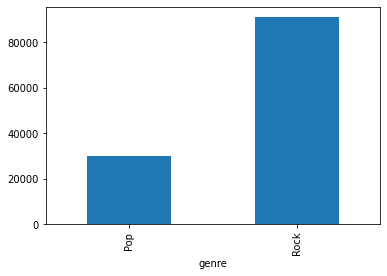

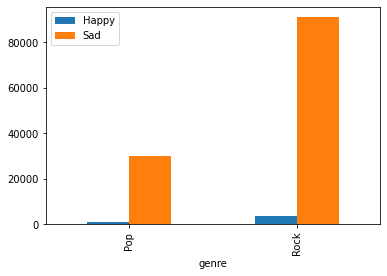

In [3]:
happy = rockpopdataset[rockpopdataset["valence"]>0.5].groupby(by=["genre"]).count()
sad = rockpopdataset[rockpopdataset["valence"]<=0.5].groupby(by=["genre"]).count()
happy["valence"].plot(kind="bar")
sad["valence"].plot(kind="bar")
mood = pd.merge(happy, sad, left_index =True, right_index = True)
fig, ax = plt.subplots()
mood[["valence_x", "valence_y"]].plot(kind="bar",ax = ax)
ax.legend(["Happy", "Sad"])

In [36]:
import pandas as pd
def clean_data(data):
    #convert tweets to lower case
    data['filtered_lyrics'] = data['filtered_lyrics'].str.lower()
    stop = set(stopwords.words('english'))

    #url removes
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b','')
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r'www\.\S+\.com','')

    #removes retweets & cc
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r'rt|cc', '')

    #hashtags removes
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r'#\S+', '')

    #user mention removes
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r'@\S+', '')

    #emoji 
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r'[^\x00-\x7F]+', '')

    #html tags
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r'<.*?>', '')

    #removes extra spaces
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r' +', ' ')

    #punctuation
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace('[{}]'.format(string.punctuation), '')

#     #stop words removes
#     data['Text'] = data['Text'].apply(lambda x: [item for item in x if item not in stop])

#     #convert preprocessed list words to string 
#     data['Text'] = data['Text'].apply(' '.join)
    return data


import spacy
import string
nlp = spacy.load("en_core_web_sm")
import nltk
from nltk.corpus import stopwords

def pos_tagging(data):
    req_tag = ['NN']
    extracted_words = []
    i = 0
    try:
        for ind, x in data.iterrows():
            doc = nlp(x["filtered_lyrics"])
            for token in doc:
                i += 1
                if token.tag_ in req_tag and token.shape_ != 'x' and token.shape_ != 'xx' and token.shape_ != 'xxx':
                    extracted_words.append(token.lemma_)
        return extracted_words
    except Exception as e:
        print("Exception", e)
        return extracted_words

extracted_words_pop = []
extracted_words_rock = []
data = clean_data(rockpopdataset)

pop_dataset = data[data["genre"] == "Pop"]
rock_dataset = data[data["genre"] == "Rock"]



# extracted_words = [item for t in extracted_words for item in t]
# from collections import Counter
# word_freq = Counter(extracted_words)
# print(word_freq.most_common(10))

In [51]:
extract_word_pop = pos_tagging(pop_dataset)
extract_words_rock = pos_tagging(rock_dataset)

extracted_words_pop.append(extract_word_pop)
extracted_words_rock.append(extract_words_rock)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anishajauhari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


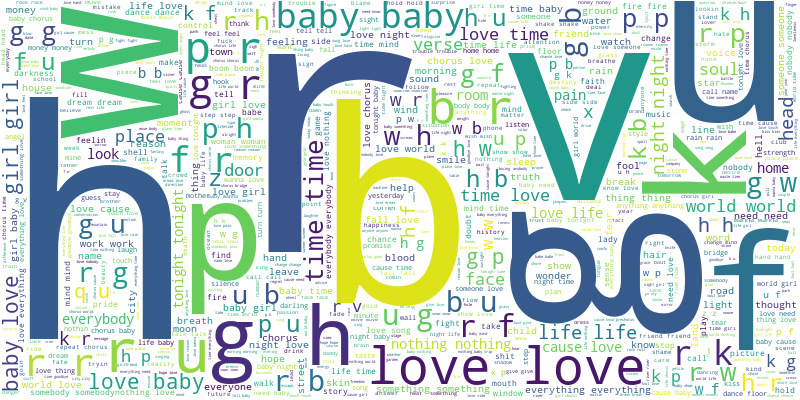

In [52]:
extracted_words_pop_flat = [item for t in extracted_words_pop for item in t]
extracted_words_pop_flat = [item for t in extracted_words_pop_flat ]
extracted_words_rock_flat = [item for t in extracted_words_rock for item in t]
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(stopwords.words('portuguese'))
stop_words.extend(stopwords.words('french'))
stop_words.extend(stopwords.words('german'))

from wordcloud import WordCloud
### POP
long_string = ','.join(list(extracted_words_pop_flat))
wordcloud = WordCloud(width = 800, height = 400,background_color="white", max_words=1000, contour_width=5, contour_color='steelblue', stopwords = stop_words)
wordcloud.generate(long_string)
wordcloud.to_image()

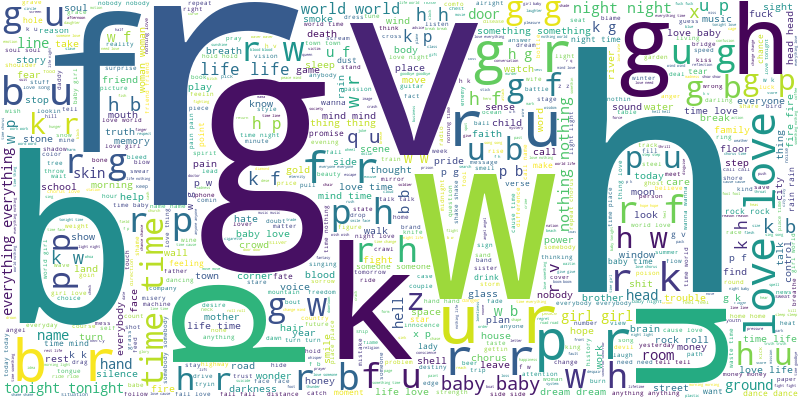

In [53]:
# ROCK
long_string = ','.join(list(extracted_words_rock_flat))
wordcloud = WordCloud(width = 800, height = 400,background_color="white", max_words=1000, contour_width=5, contour_color='steelblue', stopwords = stop_words)
wordcloud.generate(long_string)
wordcloud.to_image()

### Sentiment Analysis Using Vader

In [7]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
rockpopdataset["sentiments"] = rockpopdataset["filtered_lyrics"].apply(lambda sentence: sid.polarity_scores(sentence))
df = pd.json_normalize(rockpopdataset['sentiments'])
dataset_updated = pd.merge(rockpopdataset, df, how="inner", right_index = True, left_index= True)
dataset_updated["sentiment"] = dataset_updated["compound"].apply(lambda x : "Positive" if (x > 0.05) else ("Neutral" if (x > -0.05 and x < 0.05) else "Negative"))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/anishajauhari/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Unnamed: 0,song,year,artist,genre,filtered_lyrics,misspelled_words,unique_words,slang_words,danceability,...,liveness,valence,tempo,duration_ms,sentiments,neg,neu,pos,compound,sentiment
0,0,ego remix,2009-01-01,beyonce knowles,Pop,oh baby know im gonna cut right chase women ma...,0,95,3,0.574,...,0.0568,0.341,78.781,283933.0,"{'neg': 0.09, 'neu': 0.553, 'pos': 0.357, 'com...",0.090,0.553,0.357,0.9961,Positive
1,1,then tell me,2009-01-01,beyonce knowles,Pop,playin everything easy like seem sure still wa...,0,78,5,0.000,...,0.0000,0.000,0.000,0.0,"{'neg': 0.154, 'neu': 0.596, 'pos': 0.25, 'com...",0.154,0.596,0.250,0.8893,Positive


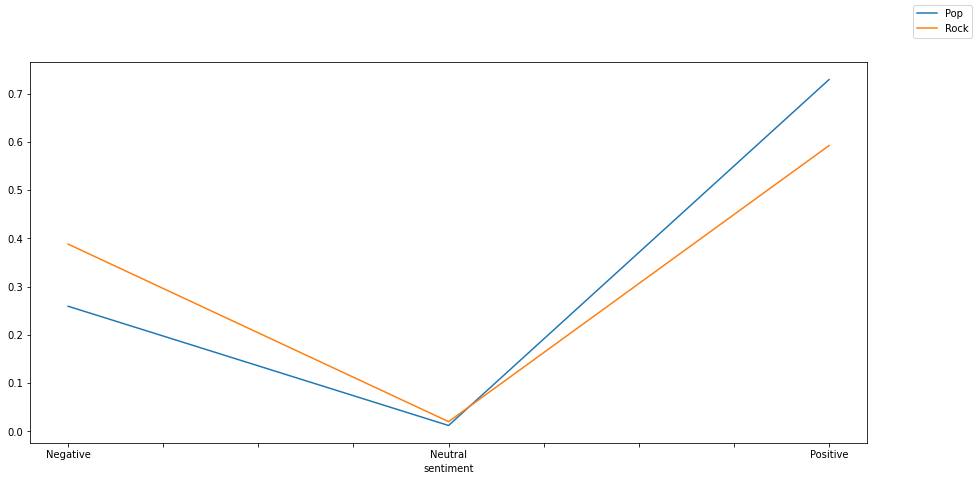

In [35]:
fig, ax = plt.subplots(figsize=(15,7))
pop_len = len(dataset_updated[dataset_updated["genre"] == "Pop"])
rock_len = len(dataset_updated[dataset_updated["genre"] == "Rock"])

groupbydataset = dataset_updated.groupby(by=["genre", "sentiment"]).count()
groupbydataset
(groupbydataset.compound.Pop/pop_len).plot(label='Pop')
(groupbydataset.compound.Rock/rock_len).plot(label='Rock')
fig.legend()